In [44]:
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# Load Variables

In [45]:
lambda_ = np.load("../NCE/NCE_results/precision_matrix_mask.npy")

# Helper Functions

In [46]:
def show_image(img):
    plt.figure(figsize=(5,5));
    plt.imshow(img, cmap="gray");
    plt.axis("off");

In [47]:
def map_to_lbl(idx):
    a = ['airplane',
         'automobile',
         'bird',
         'cat',
         'deer',
         'dog',
         'frog',
         'horse',
         'ship',
         'truck']
    return a[idx]

In [48]:
def get_stats(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    ds_np = np.array(batch[0], dtype = np.float64)
    mean = np.mean(ds_np, dtype=np.float64)
    cov = np.cov(ds_np.reshape(ds_np.shape[1],ds_np.shape[0]))
    return mean, cov

# 1) Dataset and Dataloader

In [49]:
train_tfms = T.Compose([
    T.RandomCrop((28,28)),
    T.Grayscale(),
    T.ToTensor(),
    T.Lambda(lambda x: x.view(x.shape[1]**2)) # reshaping for our input shape
])

In [50]:
ds = torchvision.datasets.CIFAR10(root = "../data/", 
                                  train = True, 
                                  transform  = train_tfms, 
                                  target_transform = None, 
                                  download = False)

In [51]:
ori_loader = DataLoader(ds,
                        batch_size=2,
                        num_workers=4,
                        shuffle=True,
                        pin_memory=True)

In [52]:
mean, cov = get_stats(ds)

In [53]:
mean

0.47596480334788627

In [54]:
cov

array([[ 0.05655098,  0.00063298,  0.0012717 , ...,  0.00231673,
        -0.00012438,  0.00021106],
       [ 0.00063298,  0.04980616, -0.00230727, ...,  0.00191505,
         0.00318821,  0.00094804],
       [ 0.0012717 , -0.00230727,  0.05800982, ...,  0.00314028,
         0.00232129, -0.00019672],
       ...,
       [ 0.00231673,  0.00191505,  0.00314028, ...,  0.05213701,
        -0.00172793, -0.00029951],
       [-0.00012438,  0.00318821,  0.00232129, ..., -0.00172793,
         0.04724637,  0.00029414],
       [ 0.00021106,  0.00094804, -0.00019672, ..., -0.00029951,
         0.00029414,  0.05217494]])

### Example visualization

In [55]:
itera = iter (ori_loader)

In [56]:
example = next(itera)

In [57]:
imgs, labels = example

'cat'

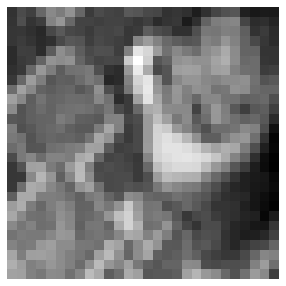

In [58]:
show_image(np.array(imgs[0]).reshape(28,28))
map_to_lbl(labels[0].item())

# 2) Whitening/Non whitening

Based on https://stackoverflow.com/questions/31528800/how-to-implement-zca-whitening-python

In [59]:
def whitening_ds(ds, lambda_, mean, epsilon=1e-5):
    mean = torch.from_numpy(np.array(mean))
    covariance_matrix = lambda_ #np.linalg.inv(lambda_)
    U,S,V = np.linalg.svd(covariance_matrix)
    zca = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
    return (torch.from_numpy(zca).double() @ (ds.T - mean).double()).permute(1,0)

In [60]:
whitening = True

In [61]:
def get_ds_whitened(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    whitened_ds = whitening_ds(batch[0], cov, mean, epsilon=1e-5)

    return whitened_ds

In [62]:
whitened_ds = get_ds_whitened(ds)

In [63]:
np.cov(np.array(whitened_ds).reshape(784, 50000))

array([[ 1.76974118e+00, -1.18967588e-05, -3.67621614e-02, ...,
        -7.74800029e-02, -2.07275863e-02,  2.56373034e-02],
       [-1.18967588e-05,  1.84883373e+00, -1.30376535e-01, ...,
         1.14182686e-01, -1.19651993e-01,  2.77965475e-02],
       [-3.67621614e-02, -1.30376535e-01,  1.64285024e+00, ...,
        -1.04206163e-01, -1.12301225e-02, -6.23764494e-02],
       ...,
       [-7.74800029e-02,  1.14182686e-01, -1.04206163e-01, ...,
         1.84902740e+00,  5.90820952e-02, -5.48303665e-02],
       [-2.07275863e-02, -1.19651993e-01, -1.12301225e-02, ...,
         5.90820952e-02,  1.61303776e+00,  4.51371486e-03],
       [ 2.56373034e-02,  2.77965475e-02, -6.23764494e-02, ...,
        -5.48303665e-02,  4.51371486e-03,  1.78014164e+00]])

In [64]:
img = whitened_ds[1]

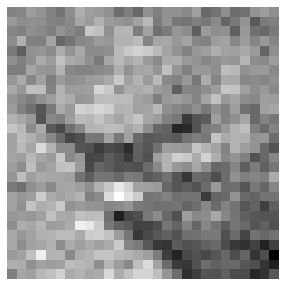

In [65]:
show_image(np.array(img.reshape(28,28)))

In [66]:
whitened_ds.shape

torch.Size([50000, 784])

# 3) Training

In [322]:
batch_size = 50

In [323]:
for i in range(whitened_ds.shape[0]):
    batch = whitened_ds[i:i+batch_size,...]
    break

In [324]:
batch.shape

torch.Size([50, 784])

In [325]:
class DeepEBM(torch.nn.Module):
    def __init__(self, std, k):
        super(DeepEBM,self).__init__()
        self.std = std
        self.in_feat = 784
        self.out_feat = k
        self.V = torch.nn.Parameter(torch.empty((self.out_feat, self.in_feat), dtype = torch.float64))
        self.W = torch.nn.Parameter(torch.empty((self.out_feat, self.out_feat), dtype = torch.float64))
        self.b = torch.nn.Parameter(torch.empty((self.in_feat, 1), dtype = torch.float64))
        self.c = torch.nn.Parameter(torch.empty((self.out_feat, 1), dtype = torch.float64))
        self.S = torch.nn.Softplus()
        self.s = torch.nn.Sigmoid()
        torch.nn.init.sparse_(self.V, sparsity=0.1)
        torch.nn.init.sparse_(self.W, sparsity=0.1)
        torch.nn.init.sparse_(self.b, sparsity=0.1)
        torch.nn.init.sparse_(self.c, sparsity=0.1)

        
    def forward(self,x):
        g_theta_x = self.s(self.V @ x.permute(1,0))
        a = torch.sum(self.S(self.W @ g_theta_x + self.c), dim = 0).reshape(1, -1)
        b_ = self.b.T @ x.permute(1,0)
        c_ = (- 0.5 * (1 / self.std**2) * torch.norm(x, dim = 1)).reshape(1, -1)
        log_ptheta = c_ + b_ + a
        #print("c",c_)
        #print("b",b_)
        #print("a",a)
        return -log_ptheta.mean()

In [329]:
model = DeepEBM(0.3, 64)

In [330]:
res = model(batch)

In [331]:
res

tensor(149.7429, dtype=torch.float64, grad_fn=<NegBackward>)

In [332]:
optim = torch.optim.SGD(model.parameters(), lr = 1e-3) # optimizer

In [334]:
arg_step = 1000

In [335]:
for i in range(whitened_ds.shape[0]):
    if i == arg_step:
        break
    optim.zero_grad()
    
    batch = whitened_ds[i:i+batch_size,...]
    loss = model(batch)
    
    loss.backward()
    print("Loss:", loss.detach().item())
    optim.step()

Loss: 149.7429046478582
Loss: 152.03665418983144
Loss: 153.4449518698651
Loss: 153.89900234818063
Loss: 153.08521701076216
Loss: 153.21439450987222
Loss: 151.10205474593153
Loss: 154.39863249870425
Loss: 155.2124634304663
Loss: 154.55372702610305
Loss: 153.737894310892
Loss: 152.46640133788375
Loss: 150.13790822528196
Loss: 153.76302432829056
Loss: 154.33091920896106
Loss: 152.31967744833105
Loss: 154.43348006929597
Loss: 153.3207605489871
Loss: 154.85280054662067
Loss: 154.32637237969823
Loss: 151.47952185765428
Loss: 149.90348212801018
Loss: 151.19225157134835
Loss: 150.7262560074692
Loss: 149.9679317769786
Loss: 145.8731322694169
Loss: 148.62686744630722
Loss: 153.2244688719514
Loss: 150.12838388394553
Loss: 149.22278796003968
Loss: 145.24240621914618
Loss: 143.29120346582656
Loss: 141.46988489231612
Loss: 139.15804538723222
Loss: 138.08128961190218
Loss: 141.2185119173794
Loss: 141.29466302423114
Loss: 139.4528377379834
Loss: 139.8143035631686
Loss: 140.1808125610717
Loss: 140.4201

Loss: -404.60544870828335
Loss: -393.0143719963627
Loss: -398.13677352343507
Loss: -388.99843942010534
Loss: -378.0221651782885
Loss: -374.2287088246077
Loss: -381.10369788437805
Loss: -381.7351780741304
Loss: -386.7847988876128
Loss: -392.3049771585198
Loss: -401.5035832416483
Loss: -396.75168921280545
Loss: -397.49149167428584
Loss: -400.9214218815991
Loss: -402.30354809919334
Loss: -393.28034487049723
Loss: -386.2195764649009
Loss: -392.3427276660319
Loss: -409.21418397653133
Loss: -414.4785695753948
Loss: -416.6427660801509
Loss: -421.2828408769453
Loss: -429.22165569405877
Loss: -433.2609408957575
Loss: -438.3691397239974
Loss: -442.2529718210192
Loss: -445.82351067888345
Loss: -430.1571527103523
Loss: -419.6358931512383
Loss: -437.17059982172856
Loss: -456.8396465706278
Loss: -455.9996555097249
Loss: -461.85562122244085
Loss: -447.6538448438182
Loss: -449.4389590664027
Loss: -452.0370662811633
Loss: -454.8382495889676
Loss: -451.0477211202389
Loss: -451.83055551844484
Loss: -464.

Loss: -1189.855246453241
Loss: -1207.2889180409736
Loss: -1193.8961114563615
Loss: -1199.2877474561637
Loss: -1204.9767662931233
Loss: -1188.9584816647132
Loss: -1166.6785959038787
Loss: -1136.9145109534384
Loss: -1139.9142350589577
Loss: -1130.4090955810275
Loss: -1136.1327732661518
Loss: -1130.2504955936718
Loss: -1135.6465519956764
Loss: -1141.0743450026823
Loss: -1112.8111622091283
Loss: -1082.351189501819
Loss: -1087.5131058516915
Loss: -1089.669751432129
Loss: -1099.9671104699398
Loss: -1093.5060925475484
Loss: -1101.6212685016085
Loss: -1084.0610593058632
Loss: -1097.5771573061638
Loss: -1102.571838011561
Loss: -1116.3510906618985
Loss: -1149.2378398161075
Loss: -1186.4605111633261
Loss: -1160.5754517904884
Loss: -1206.7490054928776
Loss: -1215.6032239281005
Loss: -1220.6928860045634
Loss: -1231.5132894797173
Loss: -1204.4419272803411
Loss: -1170.37250416241
Loss: -1176.9087213086118
Loss: -1148.4698662706583
Loss: -1192.0563418056151
Loss: -1197.4541480559794
Loss: -1201.550821

In [336]:
model.V.shape

torch.Size([64, 784])

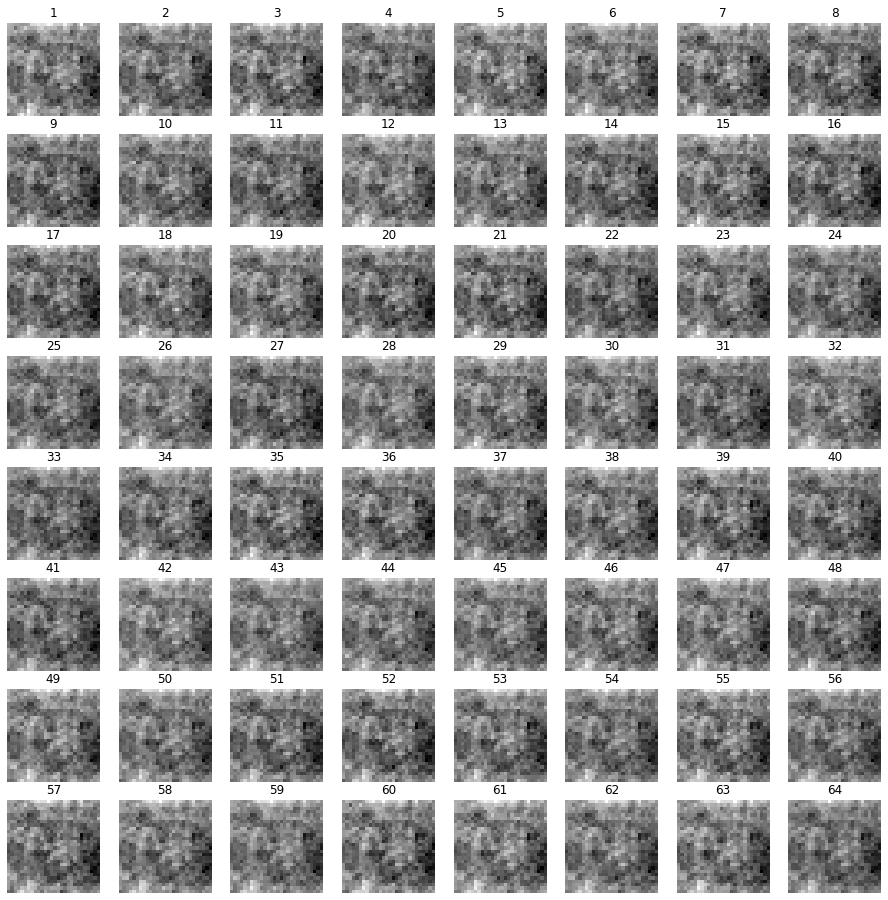

In [337]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()

for i in range(64):

    axs[i].imshow(model.V.detach().numpy()[i,...].reshape(28,28), cmap ="gray")
    axs[i].axis("off");
    axs[i].set_title(str(i+1))